In [1]:
import numpy as np
#!pip install tensorflow
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

2024-02-19 15:24:19.207552: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Grad-CAM

https://www.mathworks.com/help/deeplearning/ug/gradcam-explains-why.html

Gradient-weighted Class Activation Mapping, is a technique for making convolutional neural networks (CNNs) more transparent by visualizing the areas of input that are important for predictions for a given class. It's particularly useful for understanding the decision-making process of models in tasks like image classification. Here's a step-by-step guide on how you could implement and use Grad-CAM with a model:

Step 1: Understanding the Model Structure
First, you need a trained CNN model. Grad-CAM works by accessing the gradients and feature maps from specific layers in the network, typically the last convolutional layer.

Step 2: Selecting the Target Layer
Identify the last convolutional layer in your network or another layer of interest where you believe the model is learning relevant features for the task. This layer's feature maps will be used to create the heatmap.

Step 3: Computing Gradients
When you perform a forward pass with your input image through the model, you'll need to capture the gradients of the target class (the class for which you want to visualize the model's focus) with respect to the feature maps of the selected layer. These gradients are averaged and will serve as weights for the feature maps.

Step 4: Generating the Heatmap
By applying the weights to the feature maps and then performing a ReLU operation on the weighted combination, you produce a heatmap that highlights the important regions in the image for predicting the target class.

Step 5: Overlaying the Heatmap on the Original Image
Finally, you overlay this heatmap onto the original image to see where the model is focusing its attention when making predictions.


## Implementing 

Implementing Grad-CAM in TensorFlow involves several steps. Below, I'll provide a detailed explanation and a code example on how to do this. The process can be broken down as follows:

Load Your Pre-Trained Model: You need a trained CNN model. For simplicity, we can use one of the pre-trained models available in tf.keras.applications.

Select the Target Layer: Choose the last convolutional layer of the model or another layer that you want to investigate. This layer should ideally capture the most complex features before the classification layers.

Create a Model for Grad-CAM: Modify the model to output both the final predictions and the feature maps from the selected convolutional layer.

Compute the Gradients: Perform a forward pass with the input image to compute the gradients of the target class (which you want to visualize) with respect to the output feature maps of the selected layer.

Generate the Heatmap: Weight the feature maps with the computed gradients, apply a ReLU to the weighted feature maps to get the heatmap.

Overlay the Heatmap on the Original Image: Finally, overlay the heatmap on the original image to visualize where the model is focusing.





/var/folders/d2/n_5_62n524v01v1vk59vwv0h0000gn/T/ipykernel_2185/1543608798.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


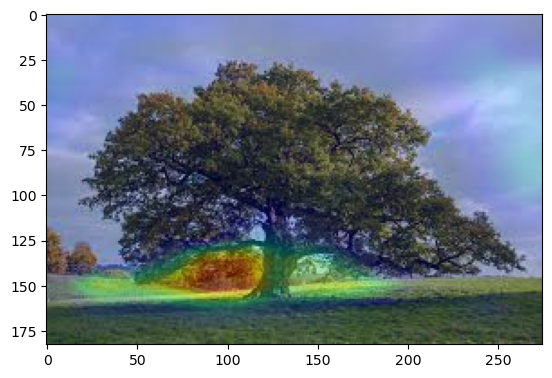

In [2]:


# Load a pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Assume we use 'block5_conv3' as the target layer for VGG16
layer_name = 'block5_conv3'
grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return preprocess_input(array)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = model(img_array, training=False)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(heatmap, image, alpha=0.4):
    if heatmap.shape != image.shape[:2]:
        heatmap = tf.image.resize(heatmap[..., np.newaxis], (image.shape[0], image.shape[1]))[..., 0]
    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + image
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

# Example usage
img_path = "image_segmentation_images/test1.jpg"
img_array = get_img_array(img_path, size=(224, 224))

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, grad_model, layer_name)

# Load the original image
img = tf.keras.preprocessing.image.load_img(img_path)
img = tf.keras.preprocessing.image.img_to_array(img)

# Overlay the heatmap on original image
superimposed_img = overlay_heatmap(heatmap, img)

# Display the image
plt.imshow(superimposed_img)
plt.show()


## Model Summary

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

# Load the pre-trained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for face detection
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# Assuming a simple binary classifier for face/no-face
predictions = Dense(1, activation='sigmoid')(x)

# This model will include the base VGG16 layers and the custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary to verify the model architecture
print(model.summary())


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   